In [1]:
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import desispec.io
%matplotlib inline
sb.set_style('white')

# In this notebook we will simulate quasar spectra using the DESI code quickqusars

#### First let us diffine some useful functions for visualization 

In [2]:
#A simple filter was added to retain some of the noise and check this is reproduced, but still be able to spot differences due to features by eye. 
#Plotspec routine was taken from someother tutorial. It allows to add the true spectra although we will not use this option here 
#Thes plots will show the three arms of the spectrograph in colors blue ['b'], red ['r'] and yellow ['z'].

from scipy.signal import medfilt
def plotspec(spectra, i, truewave=None, trueflux=None, color=['b','r','y'],nfilter=1,label=None):
    plt.plot(spectra.wave['b'], medfilt(spectra.flux['b'][i], nfilter), color=color[0], alpha=0.5,label=label)
    plt.plot(spectra.wave['r'], medfilt(spectra.flux['r'][i], nfilter), color=color[1], alpha=0.5)
    plt.plot(spectra.wave['z'], medfilt(spectra.flux['z'][i], nfilter), color=color[2], alpha=0.5)
    if truewave is not None and trueflux is not None:
        plt.plot(truewave, trueflux[i], 'k-')

    plt.axhline(0, color='k', alpha=0.2)
        
    ymax = np.max(spectra.flux['b'][i])
    ymin=0
        
    plt.ylim(ymin, ymax+3)
    plt.ylabel('Flux')
    plt.xlabel('wavelength [A]')
    plt.legend(loc='best')
    return
    
#This will compare two spectra by dividing the first over the second
def plotspec_ratio(spectra1,spectra2,i,label=None):
    ratio_b=spectra1.flux['b'][i]/spectra2.flux['b'][i]
    ratio_r=spectra1.flux['r'][i]/spectra2.flux['r'][i]
    ratio_z=spectra1.flux['z'][i]/spectra2.flux['z'][i]
    plt.plot(spectra1.wave['b'],ratio_b, color='b', alpha=0.5,label=label)
    plt.plot(spectra1.wave['r'], ratio_r, color='r', alpha=0.5)
    plt.plot(spectra1.wave['z'], ratio_z, color='y', alpha=0.5)
    plt.xlabel('wavelength [A]')
    plt.legend(loc='best')
    
#This will compare two spectra by substracting the second from the first one
def plotspec_diff(spectra1,spectra2,i,label=None):
    ratio_b=spectra1.flux['b'][i]-spectra2.flux['b'][i]
    ratio_r=spectra1.flux['r'][i]-spectra2.flux['r'][i]
    ratio_z=spectra1.flux['z'][i]-spectra2.flux['z'][i]
    plt.plot(spectra1.wave['b'],ratio_b, color='b', alpha=0.5,label=label)
    plt.plot(spectra1.wave['r'], ratio_r, color='r', alpha=0.5)
    plt.plot(spectra1.wave['z'], ratio_z, color='y', alpha=0.5)
    plt.xlabel('wavelength [A]')
    plt.legend(loc='best')
    

# Let's see what are the parameters needed to run a quickquasars simulation

In [3]:
!quickquasars --help

usage: quickquasars [-h] -i [INFILE [INFILE ...]] [-o OUTFILE]
                    [--outdir OUTDIR] [--program PROGRAM] [--seeing SEEING]
                    [--airmass AIRMASS] [--exptime EXPTIME]
                    [--moonfrac MOONFRAC] [--moonalt MOONALT]
                    [--moonsep MOONSEP] [--seed SEED] [--skyerr SKYERR]
                    [--downsampling DOWNSAMPLING] [--zmin ZMIN] [--zmax ZMAX]
                    [--wmin WMIN] [--wmax WMAX] [--dwave DWAVE]
                    [--dwave_desi DWAVE_DESI] [--zbest]
                    [--sigma_kms_fog SIGMA_KMS_FOG]
                    [--gamma_kms_zfit [GAMMA_KMS_ZFIT]]
                    [--shift_kms_los SHIFT_KMS_LOS] [--target-selection]
                    [--mags] [--bbflux] [--add-LYB]
                    [--metals [METALS [METALS ...]]]
                    [--metals-from-file [METALS_FROM_FILE]] [--dla DLA]
                    [--balprob BALPROB] [--no-simqso] [--desi-footprint]
                    [--eboss] [--extin

# We will define some of this parameters

In [4]:
zmin = 1.8
nmax = 20 # maximun number of spectra to simulate in a given pixel
seed=123 #this ensure reproducibility

In [5]:
path_mocks = '/global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0' # path to london mocks v9.0
ifile=path_mocks + '/v9.0.0/0/0/transmission-16-0.fits.gz'   #Choose one pixel to simulate the quasars. 
outdir='/global/cfs/projectdirs/desi/users/olegbg/quickquasar/tutorial/mocks/'  #Where do you want to save the files, although in this particular notebook we will be overwritring the files.

# Next, we will compare quickquasar spectra with different exposures (from 1000 to 4000) against a run with a much higher exposure time

In [6]:
exposures = ['1000','2000','3000','4000','1e8']
for exp in exposures:
    if not os.path.exists(outdir + exp):
        os.mkdir(outdir + exp)
    if not os.path.exists(outdir + exp + '/clean'):
        os.mkdir(outdir + exp + '/clean')
    specfile = outdir + exp+'/clean/spectra.fits'
    
    cmd ='quickquasars --exptime {exptime} -i {ifile} -o {outfile}  --zmin {zmin} \
    --zbest --bbflux --add-LYB --desi-footprint \
    --overwrite --nmax {nmax} --seed {seed}'.format(exptime=float(exp),ifile=ifile,outfile=specfile,zmin=zmin,nmax=nmax,seed=seed)
    !time $cmd

INFO:quickquasars.py:835:main: Load SIMQSO model
INFO:quickquasars.py:844:main: Load DeCAM and WISE filters for target selection sim.
ifilename /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:quickquasars.py:214:get_healpix_info: healpix=HPXPIXEL=0
INFO:quickquasars.py:219:get_healpix_info: nside=HPXNSIDE=16
INFO:quickquasars.py:227:get_healpix_info: hpxnest from HPXNEST = True
INFO:quickquasars.py:309:simulate_one_healpix: Read skewers in /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz, random seed = 2866
INFO:quickquasars.py:313:simulate_one_healpix: Read transmission file /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:lya_spectra.py:114:read_lya_skewers: Added LYB from transmission file
INFO:quickquasars.py:318:simulate_one_healpix: Add FOG to redshift with sigma 150 to quasar redshift
INFO:quickquasars.py:361:simulate_one_healpix: S

# Now we comapare the spectra from each simulation 

In [7]:
import glob as glob

In [8]:
dump = glob.glob(outdir+'*')

In [9]:
path_highexp = dump[-1]

In [10]:
del(dump[-1])

In [11]:
spectra_highexp = desispec.io.read_spectra(path_highexp+'/clean/spectra.fits')

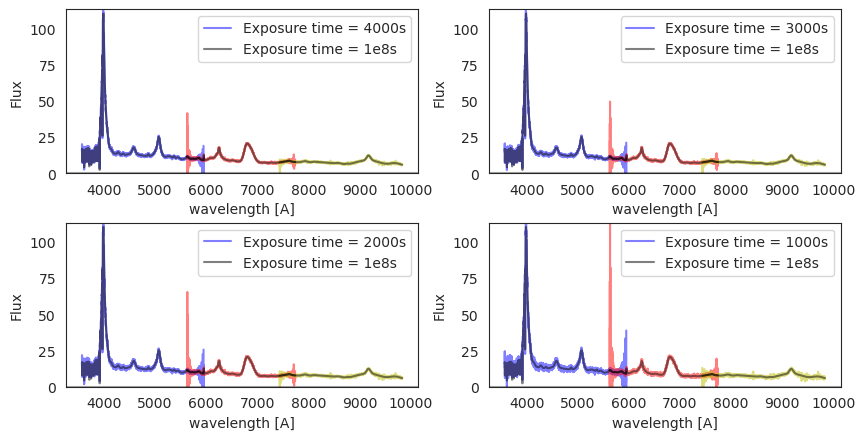

In [12]:
index = 3
plt.figure(figsize=(10,5),dpi=100)
for i in range(len(dump)):
    plt.subplot(221+i)
    exposure = dump[i].split('/')[-1]
    spectra= desispec.io.read_spectra(dump[i]+'/clean/spectra.fits')
    plotspec(spectra,index,label='Exposure time = '+exposure+'s')
    plotspec(spectra_highexp,index,color=['k','k','k'],label='Exposure time = 1e8s')
    #plt.xlim(3500,6500)
plt.subplots_adjust(hspace=0.3,wspace=.2)

#### we can compare the differences as well

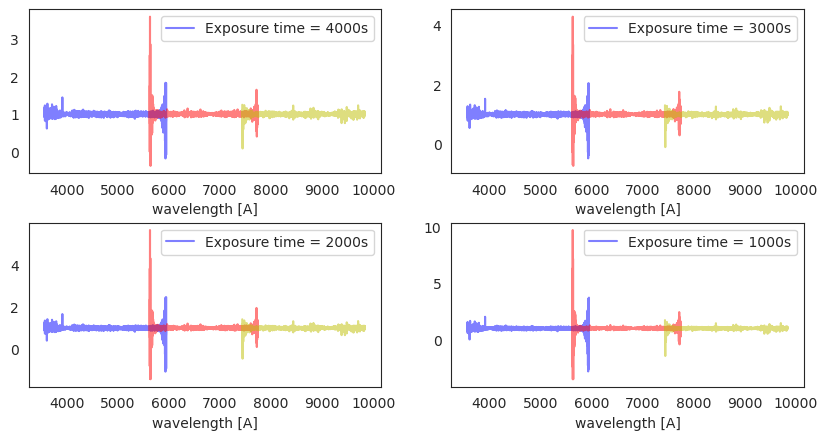

In [13]:
index = 3
plt.figure(figsize=(10,5),dpi=100)
for i in range(len(dump)):
    plt.subplot(221+i)
    exposure = dump[i].split('/')[-1]
    spectra= desispec.io.read_spectra(dump[i]+'/clean/spectra.fits')
    plotspec_ratio(spectra,spectra_highexp,index,label='Exposure time = '+exposure+'s')
    #plt.xlim(3500,4300)
plt.subplots_adjust(hspace=0.3,wspace=.2)

 # Lets look at the zbest.fits and truth.fits files

#### In zbest.fits we have information of a simulated redshift fitter for objects that quickquasars simulated. In the case for this tutorial the redshift in zbest is the true redshift but we can add some errors with:

--sigma_kms_fog

--gamma_kms_zfit

--shift_kms_los


In [14]:
import fitsio

In [15]:
data_zbest = fitsio.FITS(path_highexp+'/clean/zbest-16-0.fits')

In [16]:
data_zbest


  file: /global/cfs/projectdirs/desi/users/olegbg/quickquasar/tutorial/mocks/1e8/clean/zbest-16-0.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      ZBEST
  2      BINARY_TBL      FIBERMAP



The truth file contains information of the templates used in the simulation, the magnitude of the objects, if the spectra has contaminats,etc.



In [17]:
data_truth = fitsio.FITS(path_highexp+'/clean/truth-16-0.fits')

In [18]:
data_truth


  file: /global/cfs/projectdirs/desi/users/olegbg/quickquasar/tutorial/mocks/1e8/clean/truth-16-0.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      TRUTH
  2      BINARY_TBL      TRUTH_QSO

# so far the spectra is very clean, but we can also add contaminants. We will start with DLA's 

#### There is two ways to add DLA's, one is at random and the other is by what the transmission file. In this tutorial we will use the DLAs specified in the transmission file

In [19]:
exposures = ['1000','2000','3000','4000','1e8']
for exp in exposures:
    if not os.path.exists(outdir + exp):
        os.mkdir(outdir + exp)
    
    if not os.path.exists(outdir + exp + '/DLA'):
        os.mkdir(outdir + exp + '/DLA')
        
    specfile = outdir + exp+'/DLA/spectra.fits'
    cmd ='quickquasars --exptime {exptime} -i {ifile} -o {outfile}  --zmin {zmin} \
    --zbest --bbflux --add-LYB --desi-footprint \
    --overwrite --nmax {nmax} --seed {seed} --dla file'.format(exptime=float(exp),ifile=ifile,outfile=specfile,zmin=zmin,nmax=nmax,seed=seed)
    !time $cmd

INFO:quickquasars.py:835:main: Load SIMQSO model
INFO:quickquasars.py:844:main: Load DeCAM and WISE filters for target selection sim.
ifilename /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:quickquasars.py:214:get_healpix_info: healpix=HPXPIXEL=0
INFO:quickquasars.py:219:get_healpix_info: nside=HPXNSIDE=16
INFO:quickquasars.py:227:get_healpix_info: hpxnest from HPXNEST = True
INFO:quickquasars.py:309:simulate_one_healpix: Read skewers in /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz, random seed = 2866
INFO:quickquasars.py:313:simulate_one_healpix: Read transmission file /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:lya_spectra.py:114:read_lya_skewers: Added LYB from transmission file
INFO:lya_spectra.py:162:read_lya_skewers: Read DLAs from transmision file
INFO:quickquasars.py:318:simulate_one_healpix: Add FOG to redshift with sig

In [20]:
path_highexp

'/global/cfs/projectdirs/desi/users/olegbg/quickquasar/tutorial/mocks/1e8'

In [21]:
spectra_highexp_dla = desispec.io.read_spectra(path_highexp +'/DLA/spectra.fits')

In [22]:
truth_dla = fitsio.FITS(path_highexp+'/DLA/truth-16-0.fits')

In [23]:
truth_dla[3]['TARGETID'][:]

array([115432, 112574, 113645, 112392, 112392, 113079, 117198, 121101,
       121101, 121101])

In [24]:
mask = np.isin(truth_dla[1]['TARGETID'][:],truth_dla[3]['TARGETID'][:])

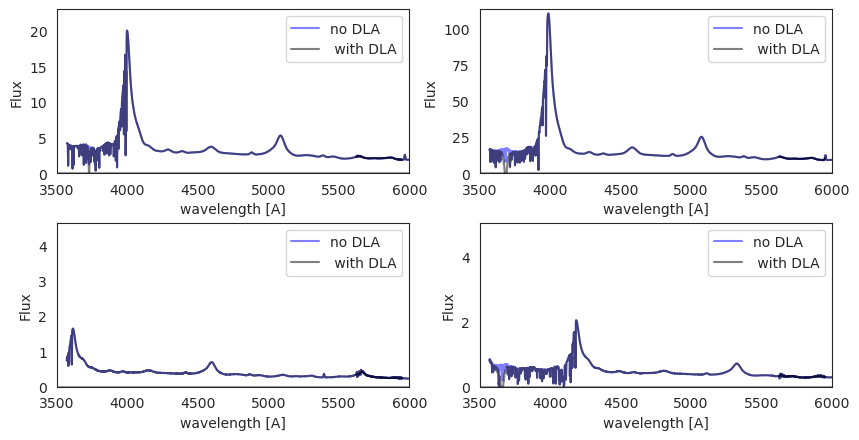

In [25]:
index = np.arange(nmax)
index = index[mask]
plt.figure(figsize=(10,5),dpi=100)
for i in range(4):
    plt.subplot(221+i)
    plotspec(spectra_highexp,index[i],color=['b','b','b'],label='no DLA')
    plotspec(spectra_highexp_dla,index[i],color=['k','k','k'],label=' with DLA')
    plt.xlim(3500,6000)
plt.subplots_adjust(hspace=0.3,wspace=.2)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


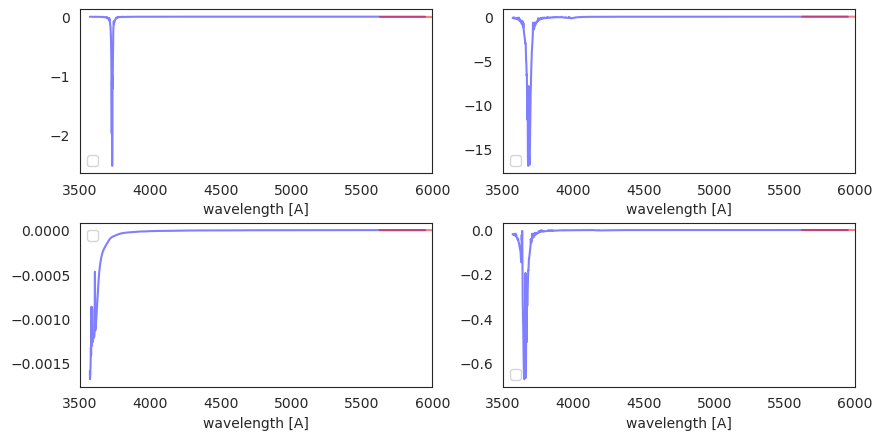

In [26]:
plt.figure(figsize=(10,5),dpi=100)
for i in range(4):
    plt.subplot(221+i)
    plotspec_diff(spectra_highexp_dla,spectra_highexp,index[i])
    plt.xlim(3500,6000)
plt.subplots_adjust(hspace=0.3,wspace=.2)

# Next, we add BALs

In [27]:
exposures = ['1000','2000','3000','4000','1e8']
for exp in exposures:
    if not os.path.exists(outdir + exp):
        os.mkdir(outdir + exp)
    if not os.path.exists(outdir + exp + '/BAL'):
        os.mkdir(outdir + exp + '/BAL')
        
    specfile = outdir + exp+'/BAL/spectra.fits'
    
    cmd ='quickquasars --exptime {exptime} -i {ifile} -o {outfile}  --zmin {zmin} \
    --zbest --bbflux --add-LYB --desi-footprint \
    --overwrite --nmax {nmax} --seed {seed} --balprob 0.5'.format(exptime=float(exp),ifile=ifile,outfile=specfile,zmin=zmin,nmax=nmax,seed=seed)
    !time $cmd

INFO:quickquasars.py:835:main: Load SIMQSO model
INFO:quickquasars.py:844:main: Load DeCAM and WISE filters for target selection sim.
INFO:io.py:971:read_basis_templates: Reading /global/cfs/cdirs/desi/spectro/templates/basis_templates/v3.2/bal_templates_v3.0.fits
ifilename /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:quickquasars.py:214:get_healpix_info: healpix=HPXPIXEL=0
INFO:quickquasars.py:219:get_healpix_info: nside=HPXNSIDE=16
INFO:quickquasars.py:227:get_healpix_info: hpxnest from HPXNEST = True
INFO:quickquasars.py:309:simulate_one_healpix: Read skewers in /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz, random seed = 2866
INFO:quickquasars.py:313:simulate_one_healpix: Read transmission file /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:lya_spectra.py:114:read_lya_skewers: Added LYB from transmission file
INFO:quickquasars.

In [28]:
truth_bal = fitsio.FITS(path_highexp+'/BAL/truth-16-0.fits')
mask = np.isin(truth_bal[1]['TARGETID'][:],truth_bal[3]['TARGETID'][:])
index = np.arange(nmax)
index = index[mask]

In [29]:
len(index)

10

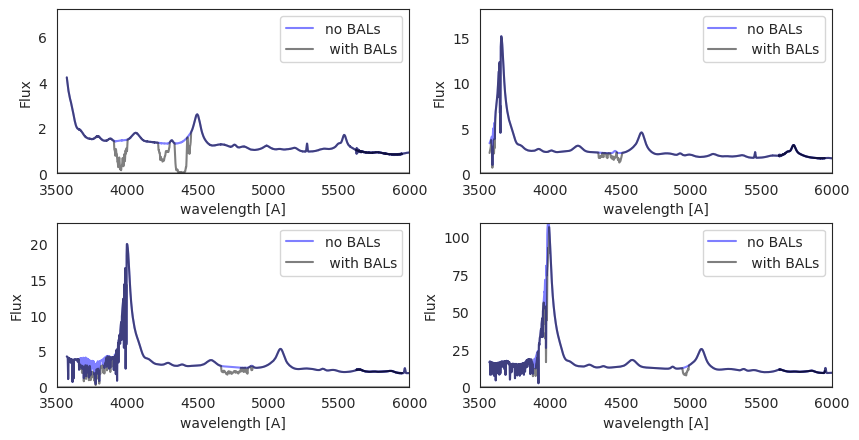

In [30]:
spectra_highexp_bal = desispec.io.read_spectra(path_highexp +'/BAL/spectra.fits')
plt.figure(figsize=(10,5),dpi=100)
for i in range(4):
    plt.subplot(221+i)
    plotspec(spectra_highexp,index[i],color=['b','b','b'],label='no BALs')
    plotspec(spectra_highexp_bal,index[i],color=['k','k','k'],label=' with BALs')
    plt.xlim(3500,6000)
plt.subplots_adjust(hspace=0.3,wspace=.2)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


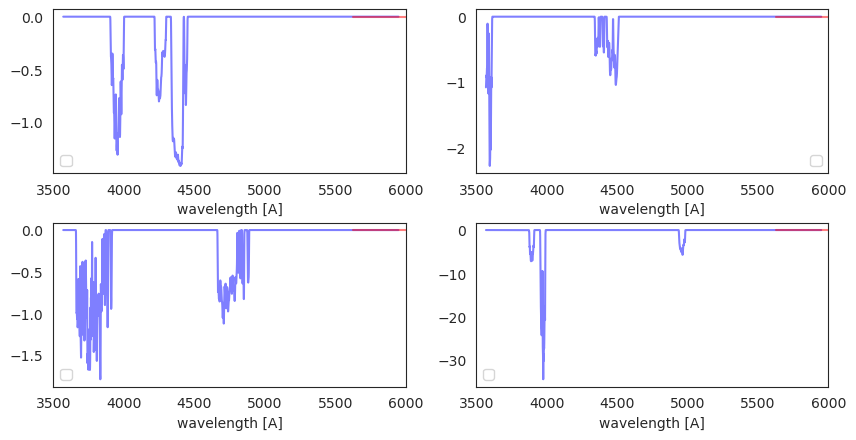

In [31]:
plt.figure(figsize=(10,5),dpi=100)
for i in range(4):
    plt.subplot(221+i)
    plotspec_diff(spectra_highexp_bal,spectra_highexp,index[i])
    plt.xlim(3500,6000)
plt.subplots_adjust(hspace=0.3,wspace=.2)

# Finally, we can also add metals

In [32]:
exposures = ['1000','2000','3000','4000','1e8']
for exp in exposures:
    if not os.path.exists(outdir + exp):
        os.mkdir(outdir + exp)
    if not os.path.exists(outdir + exp + '/metals'):
        os.mkdir(outdir + exp + '/metals')
        
    specfile = outdir + exp+'/metals/spectra.fits'
    
    cmd ='quickquasars --exptime {exptime} -i {ifile} -o {outfile}  --zmin {zmin} \
    --zbest --bbflux --add-LYB --desi-footprint \
    --overwrite --nmax {nmax} --seed {seed} --metals-from-file'.format(exptime=float(exp),ifile=ifile,outfile=specfile,zmin=zmin,nmax=nmax,seed=seed)
    !time $cmd

INFO:quickquasars.py:835:main: Load SIMQSO model
INFO:quickquasars.py:844:main: Load DeCAM and WISE filters for target selection sim.
ifilename /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:quickquasars.py:214:get_healpix_info: healpix=HPXPIXEL=0
INFO:quickquasars.py:219:get_healpix_info: nside=HPXNSIDE=16
INFO:quickquasars.py:227:get_healpix_info: hpxnest from HPXNEST = True
INFO:quickquasars.py:309:simulate_one_healpix: Read skewers in /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz, random seed = 2866
INFO:quickquasars.py:313:simulate_one_healpix: Read transmission file /global/cfs/projectdirs/desi/mocks/lya_forest/london/v9.0/v9.0.0/0/0/transmission-16-0.fits.gz
INFO:lya_spectra.py:114:read_lya_skewers: Added LYB from transmission file
INFO:lya_spectra.py:128:read_lya_skewers: Added F_Metals from transmision file
INFO:quickquasars.py:318:simulate_one_healpix: Add FOG to redshift wit

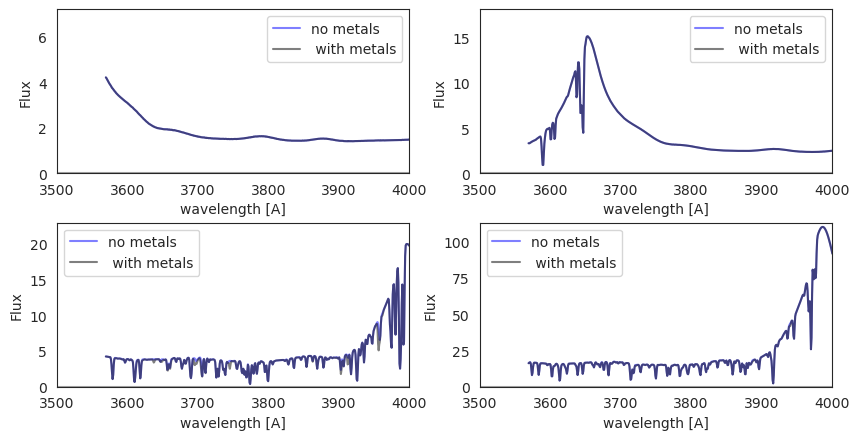

In [33]:

spectra_highexp_metals = desispec.io.read_spectra(path_highexp +'/metals/spectra.fits')
plt.figure(figsize=(10,5),dpi=100)
for i in range(4):
    plt.subplot(221+i)
    plotspec(spectra_highexp,i,color=['b','b','b'],label='no metals')
    plotspec(spectra_highexp_metals,i,color=['k','k','k'],label=' with metals')
    plt.xlim(3500,4000)
plt.subplots_adjust(hspace=0.3,wspace=.2)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


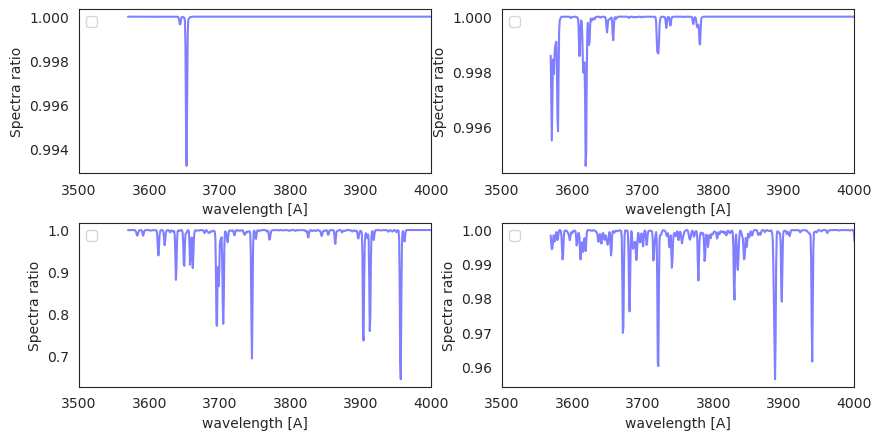

In [34]:
plt.figure(figsize=(10,5),dpi=100)
for i in range(4):
    plt.subplot(221+i)
    plotspec_ratio(spectra_highexp_metals,spectra_highexp,i)
    plt.ylabel('Spectra ratio')
    plt.legend()
    plt.xlim(3500,4000)
    #plt.ylim(0.8,1.01)
plt.subplots_adjust(hspace=0.3,wspace=.2)

# As stated in the begining, all this has been for a sinlge pixel but we can also run a quickquasar simulation for the complete mocks.

#### lets take a look to quickquasars.sh
#### Now that we have a bigger quickquasar run, we can stack the outputs for each pixel into a sinlge catalog

In [35]:
path_pixels = '/global/cfs/projectdirs/desi/users/olegbg/quickquasar/tutorial/all_pixels'
out_zcat = '/global/cfs/projectdirs/desi/users/olegbg/quickquasar/tutorial'

In [36]:
cmd='desi_zcatalog -i {ipath} -o {outdir} --fibermap'.format(ipath=path_pixels+'/spectra-16/',outdir=out_zcat+'/zcat.fits')
!time $cmd

INFO:desi_zcatalog:175:<module>: wrote /global/cfs/projectdirs/desi/users/olegbg/quickquasar/tutorial/zcat.fits

real	0m29.983s
user	0m8.995s
sys	0m1.577s


In [37]:
zcat = fitsio.FITS(out_zcat+'/zcat.fits')
zcat


  file: /global/cfs/projectdirs/desi/users/olegbg/quickquasar/tutorial/zcat.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      ZCATALOG

In [38]:
zcat[1]


  file: /global/cfs/projectdirs/desi/users/olegbg/quickquasar/tutorial/zcat.fits
  extension: 1
  type: BINARY_TBL
  extname: ZCATALOG
  rows: 267810
  column info:
    CHI2                f8  
    COEFF               f8  array[4]
    Z                   f8  
    ZERR                f8  
    ZWARN               i8  
    SPECTYPE           S96  
    SUBTYPE            S16  
    TARGETID            i8  
    DELTACHI2           f8  
    BRICKNAME           S8  
    RA                  f8  
    DEC                 f8  
    FLUX_G              f4  
    FLUX_R              f4  
    FLUX_Z              f4  

# To finish this part of the tutorial create some QA plots

#### We can look at the distriubution of objects in the sky 

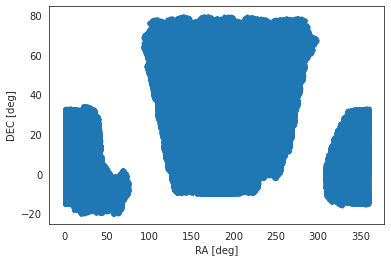

In [39]:
plt.scatter(zcat[1]['RA'][:],zcat[1]['DEC'][:],marker='.');
plt.xlabel('RA [deg]');
plt.ylabel('DEC [deg]');

#### Next we can look at the object distributions for each pixels. For that we define functions to go from angles to pixels and back

In [40]:
import healpy

In [41]:
def get_pix(ra,dec,nside=16):
    phi = ra*np.pi / 180.
    th = np.pi/2. - dec*np.pi/180.
    pix = healpy.ang2pix(nside,th,phi,nest=True)
    return pix

def pix2ang_deg(nside,pix,nest=True):
    pix_rad_dec,pix_rad_ra = healpy.pix2ang(nside,pix,nest=nest)
    pix_ra = pix_rad_ra * 180. / np.pi
    pix_dec = (np.pi/2.-pix_rad_dec)*180./np.pi
    return pix_ra, pix_dec

In [42]:
pix_zcat = get_pix(zcat[1]['RA'][:],zcat[1]['DEC'][:])

In [43]:
ra_zcat,dec_zcat = pix2ang_deg(16,np.unique(pix_zcat),nest=True)

#### Here we are just ploting the pixels, in the previous plot we plotted all the objects

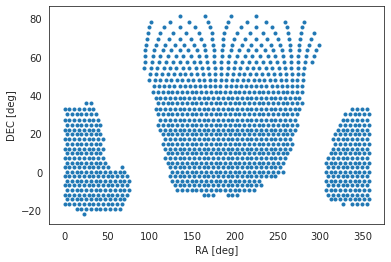

In [44]:
plt.scatter(ra_zcat,dec_zcat,marker='.');
plt.xlabel('RA [deg]');
plt.ylabel('DEC [deg]');

#### Now lets plot the density of objects per pixels as well at the mean redshift in each pixel

In [45]:
def get_density(pix,nside):
    bincounts_pix = np.bincount(pix)
    unique_pix = np.unique(pix)
    area_pix = healpy.pixelfunc.nside2pixarea(nside, degrees=True)
    density = bincounts_pix[unique_pix]/area_pix
    return density

Text(0, 0.5, 'DEC [deg]')

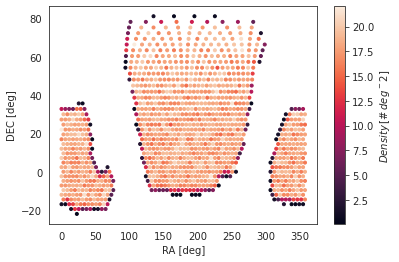

In [46]:
plot1 = plt.scatter(ra_zcat,dec_zcat,c=get_density(pix_zcat,16),marker='.')
cbar1 = plt.colorbar(plot1)
cbar1.set_label(r'$Density \, [\# \, deg^-2]$')
cbar1.update_ticks()
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

Text(0, 0.5, 'DEC [deg]')

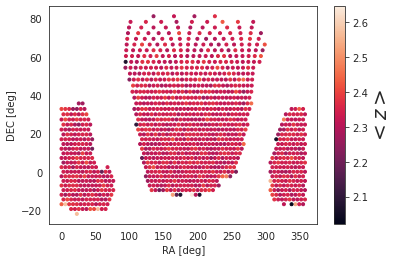

In [47]:
bincounts_pix = np.bincount(pix_zcat)
bincounts_z = np.bincount(pix_zcat,weights=zcat[1]['Z'][:])

z_pix_zcat = bincounts_z[np.unique(pix_zcat)]/bincounts_pix[np.unique(pix_zcat)]

plot1 = plt.scatter(ra_zcat,dec_zcat,c=z_pix_zcat,marker='.')
cbar1 = plt.colorbar(plot1)
cbar1.set_label(r'$<z>$',size=20)
cbar1.update_ticks()
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

# What's netxt?

#### We can run picca to calculate the flux over-densities as well as the correletions

#### - Here you can find a tutorial to run picca and do a BAO analysis: https://desi.lbl.gov/trac/wiki/LymanAlphaWG/how_to_run_picca

#### We can also run a DLA finder and BAL finder

#### - DLA finder: https://desi.lbl.gov/trac/wiki/LymanAlphaWG/DLAfinder
#### - BAL finder: https://desi.lbl.gov/trac/wiki/LymanAlphaWG/BALfinder